# EEG Signal Analysis: DFT and Signal Reconstruction

**Student ID:** $2003037$  
**Assignment:** Perform the Discrete Fourier Transform (DFT) on a segment of an EEG signal and identify the prominent frequency components (e.g., alpha, beta waves). Reconstruct the signal by using only these prominent components.


## EEG Frequency Bands
- **Delta waves (0.5-4 Hz):** Deep sleep
- **Theta waves (4-8 Hz):** Light sleep, meditation
- **Alpha waves (8-13 Hz):** Relaxed wakefulness, eyes closed
- **Beta waves (13-30 Hz):** Active thinking, concentration
- **Gamma waves (30-100 Hz):** High-level cognitive processing

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


In [21]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the EEG dataset from Kaggle
print("Loading EEG dataset from Kaggle...")

eeg_data = kagglehub.dataset_download("samnikolas/eeg-dataset")

print("✓ Dataset loaded successfully from Kaggle!")
print("First 5 records:", eeg_data.head())

print("\nEEG Dataset Information:")
print(f"Shape: {eeg_data.shape}")
print(f"Columns: {list(eeg_data.columns)}")
print(f"\nFirst few rows:")
print(eeg_data.head())

print(f"\nData statistics:")
print(eeg_data.describe())

Loading EEG dataset from Kaggle...


100%|██████████| 2.24M/2.24M [01:02<00:00, 37.4kB/s]

Extracting files...
✓ Dataset loaded successfully from Kaggle!


AttributeError: 'str' object has no attribute 'head'

In [ ]:
# Define EEG electrode positions (10-20 system)
eeg_channels = [
    'Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz',
    'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2'
]

# EEG acquisition parameters (typical values)
sampling_rate = 128  # Hz (common for EEG)
nyquist_freq = sampling_rate / 2

# Define frequency bands
frequency_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 50)
}

freq_significance = {
  'Delta': 'Deep sleep, restorative processes',
  'Theta': 'Light sleep, relaxation, creativity',
  'Alpha': 'Relaxed, calm, but alert state',
  'Beta': 'Active thinking, problem-solving, focus',
  'Gamma': 'High-level information processing, cognitive functioning'
}

print(f"Number of EEG channels: {len(eeg_channels)}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Nyquist frequency: {nyquist_freq} Hz")
print(f"\nFrequency bands defined:")
for band, (low, high) in frequency_bands.items():
    print(f"  {band}: {low}-{high} Hz \t| {freq_significance[band]}")

Number of EEG channels: 32
Sampling rate: 128 Hz
Nyquist frequency: 64.0 Hz

Frequency bands defined:
  Delta: 0.5-4 Hz 	| Deep sleep, restorative processes
  Theta: 4-8 Hz 	| Light sleep, relaxation, creativity
  Alpha: 8-13 Hz 	| Relaxed, calm, but alert state
  Beta: 13-30 Hz 	| Active thinking, problem-solving, focus
  Gamma: 30-50 Hz 	| High-level information processing, cognitive functioning


Selected channel: C3
Signal length: 8064 samples
Duration: 63.00 seconds
Signal range: -102.941 to 133.738


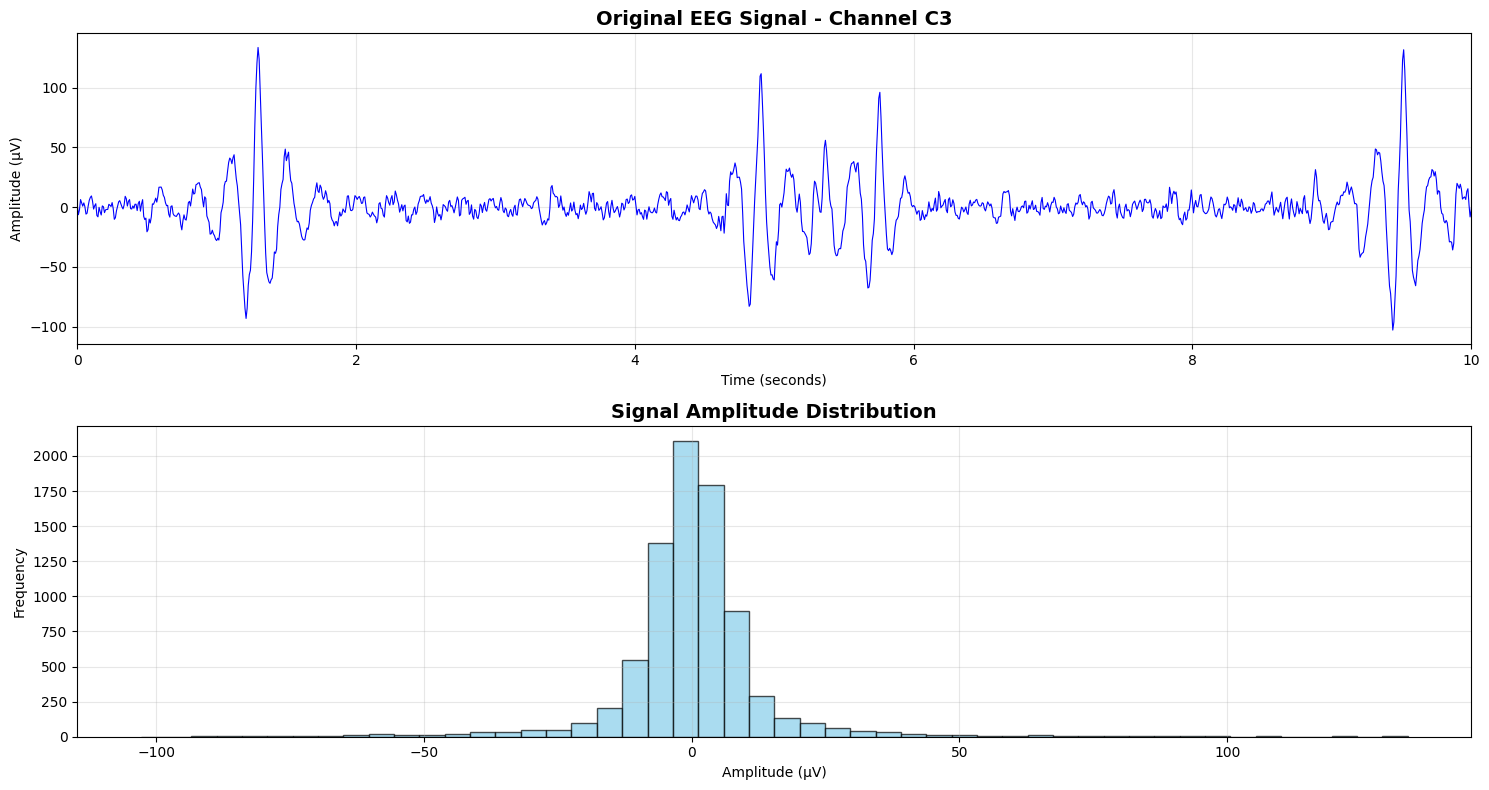

In [ ]:
# Select a specific channel for detailed analysis (C3 - motor cortex)
selected_channel = 'C3'  # Central electrode, good for motor activity
selected_signal = eeg_data[selected_channel].values

# Remove any NaN values and apply basic preprocessing
selected_signal = selected_signal[~np.isnan(selected_signal)]

# Apply a simple bandpass filter to remove artifacts
# Design a bandpass filter for EEG frequencies (0.5-50 Hz)
low_cutoff = 0.5
high_cutoff = 50

# Create time vector
time_vector = np.arange(len(selected_signal)) / sampling_rate

print(f"Selected channel: {selected_channel}")
print(f"Signal length: {len(selected_signal)} samples")
print(f"Duration: {len(selected_signal)/sampling_rate:.2f} seconds")
print(f"Signal range: {np.min(selected_signal):.3f} to {np.max(selected_signal):.3f}")

# Plot the original signal
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Time domain plot
axes[0].plot(time_vector, selected_signal, 'b-', linewidth=0.8)
axes[0].set_title(f'Original EEG Signal - Channel {selected_channel}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude (μV)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, min(10, time_vector[-1]))  # Show first 10 seconds

# Signal statistics
axes[1].hist(selected_signal, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_title('Signal Amplitude Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Amplitude (μV)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

DFT Analysis Results:
Frequency resolution: 0.0159 Hz
Maximum frequency: 63.98 Hz
Number of frequency bins: 4032


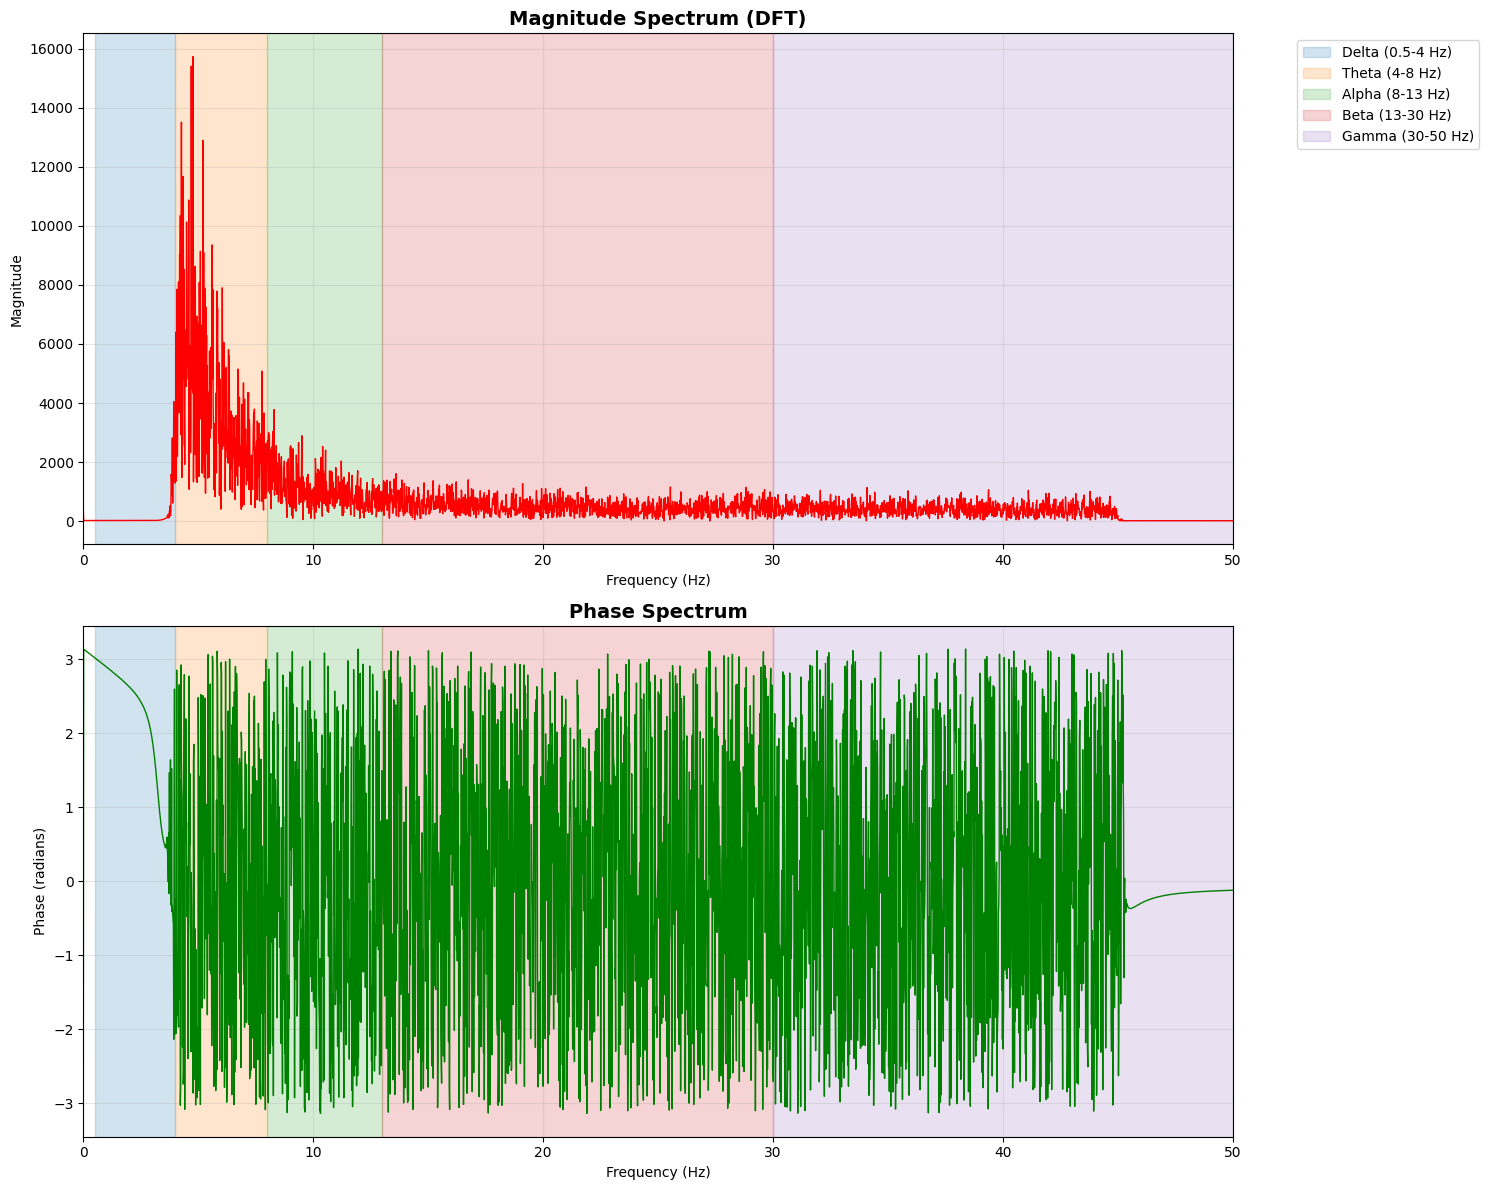

In [ ]:
# Perform Discrete Fourier Transform (DFT)
def perform_dft_analysis(signal, fs):
    """
    Perform DFT analysis on the input signal

    Parameters:
    signal: input time-domain signal
    fs: sampling frequency

    Returns:
    frequencies, magnitude_spectrum, phase_spectrum, complex_spectrum
    """
    # Calculate DFT
    N = len(signal)
    complex_spectrum = fft(signal)

    # Calculate frequency axis
    frequencies = fftfreq(N, 1/fs)

    # Calculate magnitude and phase spectra
    magnitude_spectrum = np.abs(complex_spectrum)
    phase_spectrum = np.angle(complex_spectrum)

    # Only keep positive frequencies (due to symmetry)
    positive_freq_idx = frequencies >= 0
    frequencies = frequencies[positive_freq_idx]
    magnitude_spectrum = magnitude_spectrum[positive_freq_idx]
    phase_spectrum = phase_spectrum[positive_freq_idx]
    complex_spectrum = complex_spectrum[positive_freq_idx]

    return frequencies, magnitude_spectrum, phase_spectrum, complex_spectrum

# Perform DFT analysis
freqs, magnitude, phase, complex_fft = perform_dft_analysis(selected_signal, sampling_rate)

print(f"DFT Analysis Results:")
print(f"Frequency resolution: {freqs[1] - freqs[0]:.4f} Hz")
print(f"Maximum frequency: {freqs[-1]:.2f} Hz")
print(f"Number of frequency bins: {len(freqs)}")

# Plot frequency domain analysis
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Magnitude spectrum
axes[0].plot(freqs, magnitude, 'r-', linewidth=1)
axes[0].set_title('Magnitude Spectrum (DFT)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlim(0, 50)  # Focus on EEG relevant frequencies
axes[0].grid(True, alpha=0.3)

# Phase spectrum
axes[1].plot(freqs, phase, 'g-', linewidth=1)
axes[1].set_title('Phase Spectrum', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Phase (radians)')
axes[1].set_xlim(0, 50)
axes[1].grid(True, alpha=0.3)

# Add frequency band regions
for i, (band_name, (low, high)) in enumerate(frequency_bands.items()):
    if high <= 50:  # Only show bands within our frequency range
        color = plt.cm.tab10(i)
        for ax in axes:
            ax.axvspan(low, high, alpha=0.2, color=color, label=f'{band_name} ({low}-{high} Hz)')

axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Identify prominent frequency components
def identify_prominent_frequencies(frequencies, magnitude, threshold_percentile=95):
    """
    Identify prominent frequency components based on magnitude threshold

    Parameters:
    frequencies: frequency array
    magnitude: magnitude spectrum
    threshold_percentile: percentile threshold for prominence

    Returns:
    prominent_freqs, prominent_indices, threshold
    """
    # Calculate threshold based on percentile
    threshold = np.percentile(magnitude, threshold_percentile)

    # Find frequencies above threshold
    prominent_indices = np.where(magnitude > threshold)[0]
    prominent_freqs = frequencies[prominent_indices]

    return prominent_freqs, prominent_indices, threshold

# Identify prominent frequencies
prominent_freqs, prominent_indices, magnitude_threshold = identify_prominent_frequencies(
    freqs, magnitude, threshold_percentile=90
)

print(f"Prominent Frequency Analysis:")
print(f"  Magnitude threshold (90th percentile): {magnitude_threshold:.2f}")
print(f"  Number of prominent frequency components: {len(prominent_freqs)}")
print(f"  Prominent frequencies (first 20): {prominent_freqs[:20]}")

# Analyze frequency content by band
band_power = {}
band_prominent_freqs = {}

for band_name, (low_freq, high_freq) in frequency_bands.items():
    # Find frequencies in this band
    band_mask = (freqs >= low_freq) & (freqs <= high_freq)
    band_freqs = freqs[band_mask]
    band_magnitude = magnitude[band_mask]

    # Calculate total power in band
    band_power[band_name] = np.sum(band_magnitude**2)

    # Find prominent frequencies in this band
    prominent_in_band = prominent_freqs[(prominent_freqs >= low_freq) & (prominent_freqs <= high_freq)]
    band_prominent_freqs[band_name] = prominent_in_band

    print(f"\n{band_name} band ({low_freq}-{high_freq} Hz):")
    print(f"  Total power: {band_power[band_name]:.2e}")
    print(f"  Prominent frequencies: {len(prominent_in_band)}")
    if len(prominent_in_band) > 0:
        print(f"  Prominent freq values: {prominent_in_band[:10]}")

Prominent Frequency Analysis:
  Magnitude threshold (90th percentile): 1063.01
  Number of prominent frequency components: 404
  Prominent frequencies (first 20): [3.82539683 3.84126984 3.87301587 3.9047619  3.92063492 3.93650794
 3.95238095 3.96825397 3.98412698 4.         4.01587302 4.03174603
 4.04761905 4.06349206 4.07936508 4.0952381  4.11111111 4.12698413
 4.14285714 4.15873016]

Delta band (0.5-4 Hz):
  Total power: 6.26e+07
  Prominent frequencies: 10
  Prominent freq values: [3.82539683 3.84126984 3.87301587 3.9047619  3.92063492 3.93650794
 3.95238095 3.96825397 3.98412698 4.        ]

Theta band (4-8 Hz):
  Total power: 5.45e+09
  Prominent frequencies: 226
  Prominent freq values: [4.         4.01587302 4.03174603 4.04761905 4.06349206 4.07936508
 4.0952381  4.11111111 4.12698413 4.14285714]

Alpha band (8-13 Hz):
  Total power: 4.82e+08
  Prominent frequencies: 133
  Prominent freq values: [8.         8.01587302 8.03174603 8.04761905 8.06349206 8.0952381
 8.11111111 8.1428

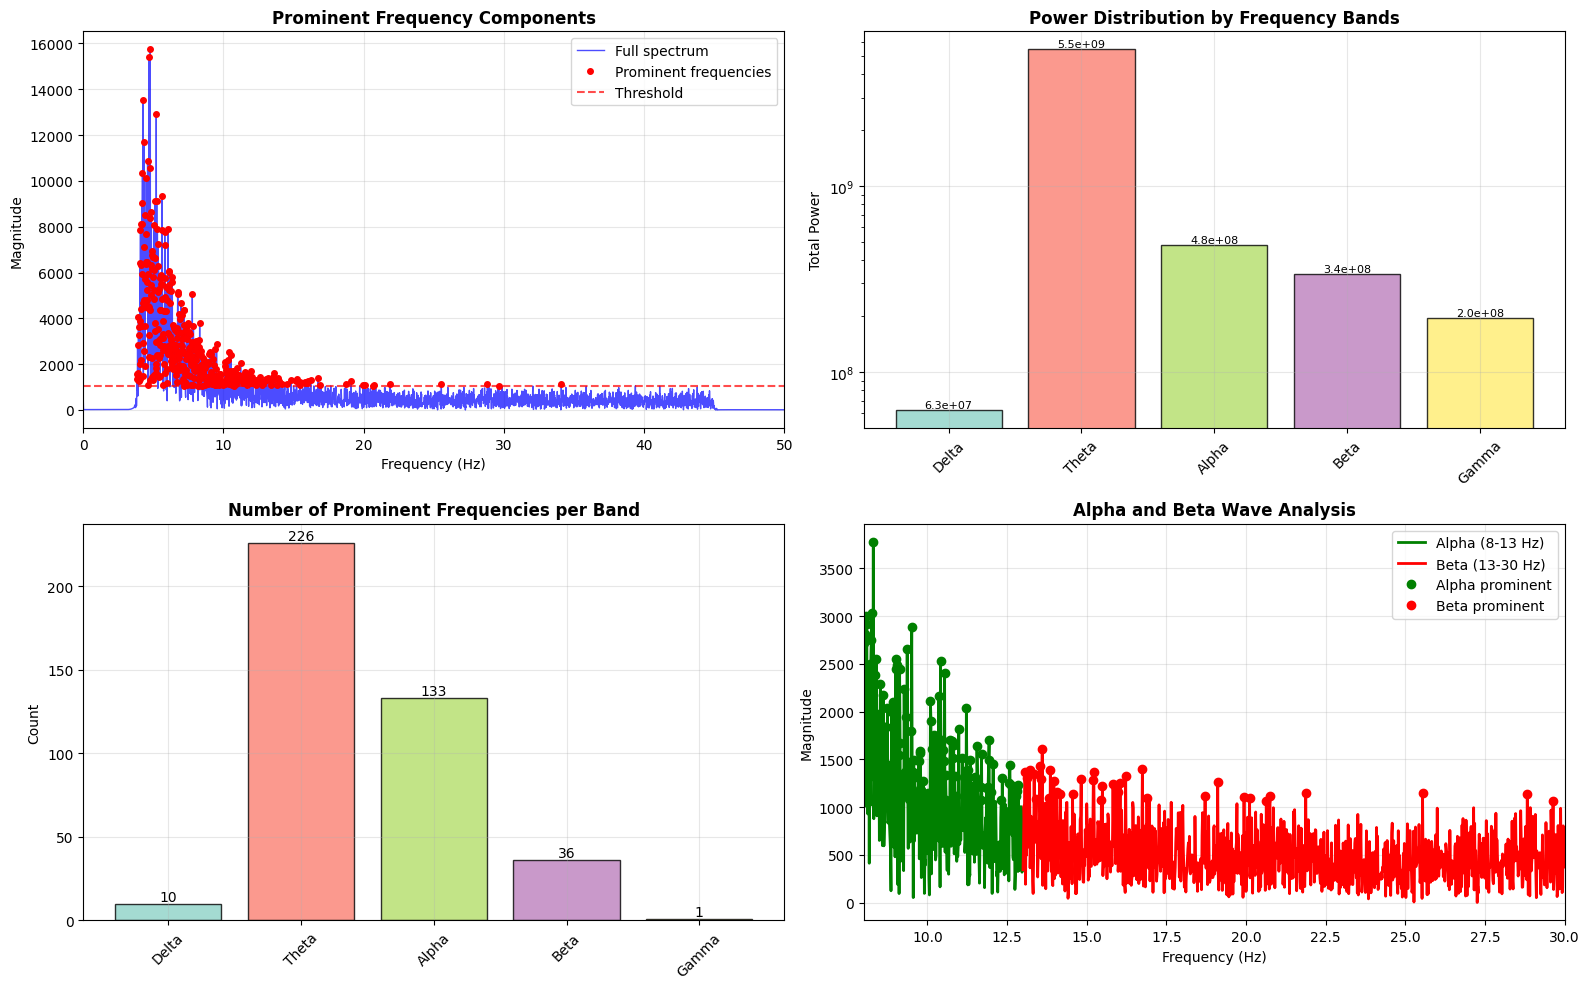

In [ ]:
# Visualize prominent frequencies and frequency bands
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Magnitude spectrum with prominent frequencies highlighted
axes[0,0].plot(freqs, magnitude, 'b-', linewidth=1, alpha=0.7, label='Full spectrum')
axes[0,0].plot(prominent_freqs, magnitude[prominent_indices], 'ro', markersize=4, label='Prominent frequencies')
axes[0,0].axhline(y=magnitude_threshold, color='red', linestyle='--', alpha=0.7, label='Threshold')
axes[0,0].set_title('Prominent Frequency Components', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Frequency (Hz)')
axes[0,0].set_ylabel('Magnitude')
axes[0,0].set_xlim(0, 50)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Power distribution by frequency bands
band_names = list(band_power.keys())
band_powers = list(band_power.values())
colors = plt.cm.Set3(np.linspace(0, 1, len(band_names)))

bars = axes[0,1].bar(band_names, band_powers, color=colors, alpha=0.8, edgecolor='black')
axes[0,1].set_title('Power Distribution by Frequency Bands', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Total Power')
axes[0,1].set_yscale('log')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, power in zip(bars, band_powers):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height, f'{power:.1e}',
                   ha='center', va='bottom', fontsize=8)

# Plot 3: Number of prominent frequencies per band
band_counts = [len(band_prominent_freqs[band]) for band in band_names]
bars = axes[1,0].bar(band_names, band_counts, color=colors, alpha=0.8, edgecolor='black')
axes[1,0].set_title('Number of Prominent Frequencies per Band', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, band_counts):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height, str(count),
                   ha='center', va='bottom', fontsize=10)

# Plot 4: Detailed view of alpha and beta bands
alpha_mask = (freqs >= 8) & (freqs <= 13)
beta_mask = (freqs >= 13) & (freqs <= 30)

axes[1,1].plot(freqs[alpha_mask], magnitude[alpha_mask], 'g-', linewidth=2, label='Alpha (8-13 Hz)')
axes[1,1].plot(freqs[beta_mask], magnitude[beta_mask], 'r-', linewidth=2, label='Beta (13-30 Hz)')

# Highlight prominent frequencies in these bands
alpha_prominent = prominent_freqs[(prominent_freqs >= 8) & (prominent_freqs <= 13)]
beta_prominent = prominent_freqs[(prominent_freqs >= 13) & (prominent_freqs <= 30)]

if len(alpha_prominent) > 0:
    alpha_prominent_indices = [np.where(freqs == f)[0][0] for f in alpha_prominent if f in freqs]
    axes[1,1].plot(alpha_prominent, magnitude[alpha_prominent_indices], 'go', markersize=6, label='Alpha prominent')

if len(beta_prominent) > 0:
    beta_prominent_indices = [np.where(freqs == f)[0][0] for f in beta_prominent if f in freqs]
    axes[1,1].plot(beta_prominent, magnitude[beta_prominent_indices], 'ro', markersize=6, label='Beta prominent')

axes[1,1].set_title('Alpha and Beta Wave Analysis', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Magnitude')
axes[1,1].set_xlim(8, 30)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Signal reconstruction using only prominent frequency components
def reconstruct_signal_from_frequencies(original_fft, prominent_indices, signal_length):
    """
    Reconstruct signal using only prominent frequency components

    Parameters:
    original_fft: original FFT of the signal
    prominent_indices: indices of prominent frequency components
    signal_length: length of the original signal

    Returns:
    reconstructed_signal
    """
    # Create a new FFT with only prominent components
    filtered_fft = np.zeros_like(original_fft, dtype=complex)
    filtered_fft[prominent_indices] = original_fft[prominent_indices]

    # Create the symmetric negative frequency components
    full_fft = np.zeros(signal_length, dtype=complex)
    full_fft[:len(filtered_fft)] = filtered_fft

    # Add symmetric components for negative frequencies (except DC and Nyquist)
    for i in range(1, len(filtered_fft)-1):
        if i < len(full_fft) - i:
            full_fft[-i] = np.conj(filtered_fft[i])

    # Perform inverse FFT
    reconstructed_signal = np.real(ifft(full_fft))

    return reconstructed_signal, filtered_fft

# Reconstruct signal using all prominent frequencies
reconstructed_signal, filtered_fft = reconstruct_signal_from_frequencies(
    complex_fft, prominent_indices, len(selected_signal)
)

print(f"Signal Reconstruction Results:")
print(f"Original signal length: {len(selected_signal)}")
print(f"Reconstructed signal length: {len(reconstructed_signal)}")
print(f"Frequency components used: {len(prominent_indices)} out of {len(complex_fft)}")
print(f"Compression ratio: {len(prominent_indices)/len(complex_fft)*100:.2f}%")

# Calculate reconstruction metrics
mse = np.mean((selected_signal - reconstructed_signal)**2)
rmse = np.sqrt(mse)
correlation = np.corrcoef(selected_signal, reconstructed_signal)[0,1]

# Calculate signal-to-noise ratio (SNR)
signal_power = np.mean(selected_signal**2)
noise_power = mse
snr_db = 10 * np.log10(signal_power / noise_power)

print(f"\nReconstruction Quality Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Correlation coefficient: {correlation:.6f}")
print(f"Signal-to-Noise Ratio (SNR): {snr_db:.2f} dB")

Signal Reconstruction Results:
Original signal length: 8064
Reconstructed signal length: 8064
Frequency components used: 404 out of 4032
Compression ratio: 10.02%

Reconstruction Quality Metrics:
Mean Squared Error (MSE): 17.720390
Root Mean Squared Error (RMSE): 4.209559
Correlation coefficient: 0.954826
Signal-to-Noise Ratio (SNR): 10.54 dB


In [ ]:
# Reconstruct signals for specific frequency bands
def reconstruct_signal_by_band(original_fft, frequencies, band_range, signal_length):
    """
    Reconstruct signal using only frequencies in a specific band
    """
    band_mask = (frequencies >= band_range[0]) & (frequencies <= band_range[1])
    band_indices = np.where(band_mask)[0]

    if len(band_indices) == 0:
        return np.zeros(signal_length), np.zeros_like(original_fft)

    return reconstruct_signal_from_frequencies(original_fft, band_indices, signal_length)

# Reconstruct signals for each frequency band
band_reconstructions = {}
band_filtered_ffts = {}

for band_name, (low_freq, high_freq) in frequency_bands.items():
    if high_freq <= nyquist_freq:  # Only process bands within Nyquist frequency
        recon_signal, filtered_fft_band = reconstruct_signal_by_band(
            complex_fft, freqs, (low_freq, high_freq), len(selected_signal)
        )
        band_reconstructions[band_name] = recon_signal
        band_filtered_ffts[band_name] = filtered_fft_band

        # Calculate band-specific metrics
        band_mse = np.mean((selected_signal - recon_signal)**2)
        band_correlation = np.corrcoef(selected_signal, recon_signal)[0,1] if np.std(recon_signal) > 0 else 0

        print(f"{band_name} band reconstruction:")
        print(f"  MSE: {band_mse:.6f}")
        print(f"  Correlation: {band_correlation:.6f}")
        print(f"  Signal energy: {np.sum(recon_signal**2):.2e}")

print("\nBand reconstruction completed!")

Delta band reconstruction:
  MSE: 198.713880
  Correlation: 0.097938
  Signal energy: 1.55e+04
Theta band reconstruction:
  MSE: 32.961821
  Correlation: 0.914181
  Signal energy: 1.35e+06
Alpha band reconstruction:
  MSE: 185.829158
  Correlation: 0.271682
  Signal energy: 1.19e+05
Beta band reconstruction:
  MSE: 190.260056
  Correlation: 0.227436
  Signal energy: 8.37e+04
Gamma band reconstruction:
  MSE: 194.621624
  Correlation: 0.173171
  Signal energy: 4.85e+04

Band reconstruction completed!


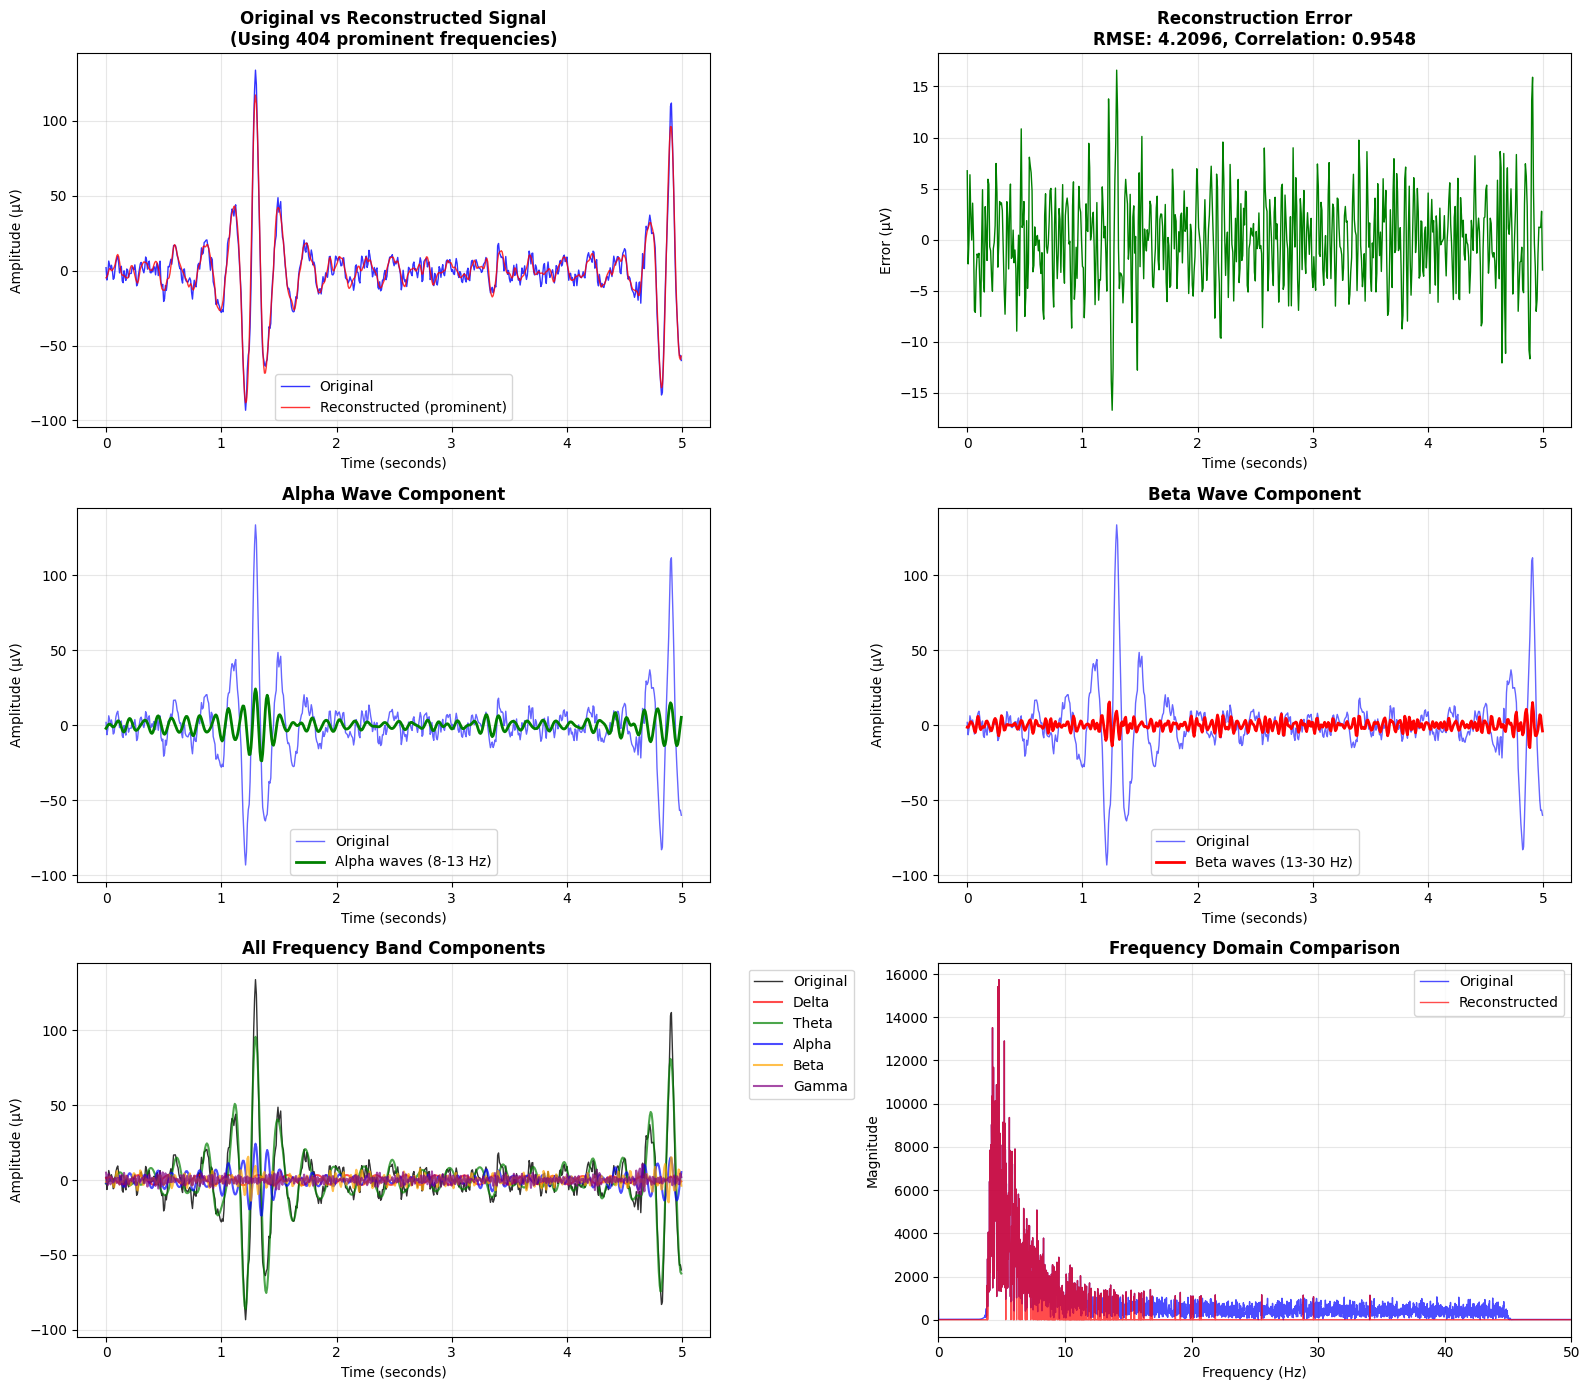

In [ ]:
# Visualize original vs reconstructed signals
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Time range for detailed view (first 5 seconds)
time_range = min(5 * sampling_rate, len(time_vector))
time_subset = time_vector[:time_range]
original_subset = selected_signal[:time_range]
reconstructed_subset = reconstructed_signal[:time_range]

# Plot 1: Original vs Reconstructed (full prominent frequencies)
axes[0,0].plot(time_subset, original_subset, 'b-', linewidth=1, label='Original', alpha=0.8)
axes[0,0].plot(time_subset, reconstructed_subset, 'r-', linewidth=1, label='Reconstructed (prominent)', alpha=0.8)
axes[0,0].set_title(f'Original vs Reconstructed Signal\n(Using {len(prominent_indices)} prominent frequencies)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Time (seconds)')
axes[0,0].set_ylabel('Amplitude (μV)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Reconstruction error
error_signal = original_subset - reconstructed_subset
axes[0,1].plot(time_subset, error_signal, 'g-', linewidth=1)
axes[0,1].set_title(f'Reconstruction Error\nRMSE: {rmse:.4f}, Correlation: {correlation:.4f}', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Time (seconds)')
axes[0,1].set_ylabel('Error (μV)')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Alpha wave reconstruction
if 'Alpha' in band_reconstructions:
    alpha_recon = band_reconstructions['Alpha'][:time_range]
    axes[1,0].plot(time_subset, original_subset, 'b-', linewidth=1, label='Original', alpha=0.6)
    axes[1,0].plot(time_subset, alpha_recon, 'g-', linewidth=2, label='Alpha waves (8-13 Hz)')
    axes[1,0].set_title('Alpha Wave Component', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Time (seconds)')
    axes[1,0].set_ylabel('Amplitude (μV)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# Plot 4: Beta wave reconstruction
if 'Beta' in band_reconstructions:
    beta_recon = band_reconstructions['Beta'][:time_range]
    axes[1,1].plot(time_subset, original_subset, 'b-', linewidth=1, label='Original', alpha=0.6)
    axes[1,1].plot(time_subset, beta_recon, 'r-', linewidth=2, label='Beta waves (13-30 Hz)')
    axes[1,1].set_title('Beta Wave Component', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Time (seconds)')
    axes[1,1].set_ylabel('Amplitude (μV)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

# Plot 5: Combined frequency bands
axes[2,0].plot(time_subset, original_subset, 'k-', linewidth=1, label='Original', alpha=0.8)
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, (band_name, recon_signal) in enumerate(band_reconstructions.items()):
    if len(recon_signal) > 0:
        axes[2,0].plot(time_subset, recon_signal[:time_range],
                      color=colors[i % len(colors)], linewidth=1.5,
                      label=f'{band_name}', alpha=0.7)
axes[2,0].set_title('All Frequency Band Components', fontsize=12, fontweight='bold')
axes[2,0].set_xlabel('Time (seconds)')
axes[2,0].set_ylabel('Amplitude (μV)')
axes[2,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[2,0].grid(True, alpha=0.3)

# Plot 6: Frequency domain comparison
recon_freqs, recon_magnitude, _, _ = perform_dft_analysis(reconstructed_signal, sampling_rate)
axes[2,1].plot(freqs, magnitude, 'b-', linewidth=1, label='Original', alpha=0.7)
axes[2,1].plot(recon_freqs, recon_magnitude, 'r-', linewidth=1, label='Reconstructed', alpha=0.7)
axes[2,1].set_title('Frequency Domain Comparison', fontsize=12, fontweight='bold')
axes[2,1].set_xlabel('Frequency (Hz)')
axes[2,1].set_ylabel('Magnitude')
axes[2,1].set_xlim(0, 50)
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Quantitative analysis of reconstruction quality
print("="*80)
print("\t\tQUANTITATIVE ANALYSIS OF EEG SIGNAL RECONSTRUCTION")
print("="*80)

# Calculate percentage of energy preserved
original_energy = np.sum(selected_signal**2)
reconstructed_energy = np.sum(reconstructed_signal**2)
energy_preservation = (reconstructed_energy / original_energy) * 100

print(f"\n1. ENERGY ANALYSIS:")
print(f"   Original signal energy: {original_energy:.2e}")
print(f"   Reconstructed signal energy: {reconstructed_energy:.2e}")
print(f"   Energy preservation: {energy_preservation:.2f}%")

# Frequency component analysis
print(f"\n2. FREQUENCY COMPONENT ANALYSIS:")
print(f"   Total frequency bins: {len(freqs)}")
print(f"   Prominent frequency bins: {len(prominent_indices)}")
print(f"   Data compression ratio: {(1 - len(prominent_indices)/len(freqs))*100:.2f}%")

# Band-wise energy analysis
print(f"\n3. FREQUENCY BAND ENERGY DISTRIBUTION:")
total_band_energy = sum(band_power.values())
for band_name, power in band_power.items():
    percentage = (power / total_band_energy) * 100
    num_prominent = len(band_prominent_freqs[band_name])
    print(f"   {band_name:6s}: {percentage:6.2f}% of total power, {num_prominent:3d} prominent frequencies")

# Reconstruction quality metrics
print(f"\n4. RECONSTRUCTION QUALITY:")
print(f"   Correlation coefficient: {correlation:.6f}")
print(f"   Signal-to-Noise Ratio: {snr_db:.2f} dB")
print(f"   Normalized RMSE: {rmse/np.std(selected_signal)*100:.2f}%")


print(f"\n5. PROMINENT FREQUENCY DETAILS:")
if len(prominent_freqs) > 0:
    print(f"   Frequency range: {prominent_freqs.min():.2f} - {prominent_freqs.max():.2f} Hz")
    print(f"   Most prominent frequencies (top 10):")

    # Get top 10 most prominent frequencies
    top_indices = np.argsort(magnitude[prominent_indices])[-10:][::-1]
    top_frequencies = prominent_freqs[top_indices]
    top_magnitudes = magnitude[prominent_indices][top_indices]

    for i, (freq, mag) in enumerate(zip(top_frequencies, top_magnitudes)):
        # Determine which band this frequency belongs to
        band_assignment = "Unknown"
        for band_name, (low, high) in frequency_bands.items():
            if low <= freq <= high:
                band_assignment = band_name
                break
        print(f"      {i+1:2d}. {freq:6.2f} Hz (magnitude: {mag:8.2f}) - {band_assignment} band")

print("\n" + "="*80)
print("\t\t\tANALYSIS COMPLETE !")
print("="*80)

		QUANTITATIVE ANALYSIS OF EEG SIGNAL RECONSTRUCTION

1. ENERGY ANALYSIS:
   Original signal energy: 1.62e+06
   Reconstructed signal energy: 1.48e+06
   Energy preservation: 91.17%

2. FREQUENCY COMPONENT ANALYSIS:
   Total frequency bins: 4032
   Prominent frequency bins: 404
   Data compression ratio: 89.98%

3. FREQUENCY BAND ENERGY DISTRIBUTION:
   Delta :   0.96% of total power,  10 prominent frequencies
   Theta :  83.50% of total power, 226 prominent frequencies
   Alpha :   7.37% of total power, 133 prominent frequencies
   Beta  :   5.17% of total power,  36 prominent frequencies
   Gamma :   3.00% of total power,   1 prominent frequencies

4. RECONSTRUCTION QUALITY:
   Correlation coefficient: 0.954826
   Signal-to-Noise Ratio: 10.54 dB
   Normalized RMSE: 29.72%

5. PROMINENT FREQUENCY DETAILS:
   Frequency range: 3.83 - 34.10 Hz
   Most prominent frequencies (top 10):
       1.   4.78 Hz (magnitude: 15740.63) - Theta band
       2.   4.70 Hz (magnitude: 15415.08) - Theta b